In [1]:
import os
import random
from random import shuffle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from fedlab.contrib.dataset.adult import Adult
from fedlab.utils.dataset.partition import AdultPartitioner
from torch.utils.data import DataLoader, Subset

In [4]:
class TransformedAdult(Adult):
    def __init__(self, root, train=False, download=True, transform=None):
        super().__init__(root, train, download)
        self.transform = transform

    def __getitem__(self, index):
        features, target = self.data[index], self.targets[index]
        if self.transform:
            features = self.transform(features)

        return torch.tensor(features, dtype=torch.float32), torch.tensor(
            target, dtype=torch.int64
        )


class TabularTransform:
    def __init__(self, noise_std=0.01, feature_scaling=True):
        self.noise_std = noise_std
        self.feature_scaling = feature_scaling

    def __call__(self, features):
        features = features + np.random.normal(0, self.noise_std, size=features.shape)
        if self.feature_scaling:
            features = (features - features.min(axis=0)) / (
                features.max(axis=0) - features.min(axis=0) + 1e-8
            )

        return features

In [5]:
# Dataset and Partitioner
transform = TabularTransform(noise_std=0.05, feature_scaling=True)

dataset_path = os.path.join("path_to_data", "adult-a9a")
trainset = TransformedAdult(
    dataset_path, train=True, download=True, transform=transform
)
testset = TransformedAdult(
    dataset_path, train=False, download=True, transform=transform
)

Local file path_to_data\adult-a9a\a9a loaded.
Local file path_to_data\adult-a9a\a9a.t loaded.


In [6]:
# Parameters
num_clients = 10
seed = 2021
alpha_values = [0.1, 0.3, 1.0, 5.0, 10.0]

In [7]:
# Generate partitions
partitions = {}
for alpha in alpha_values:
    partitions[f"Dirichlet_alpha_{alpha}"] = AdultPartitioner(
        trainset.targets,
        num_clients=num_clients,
        partition="noniid-labeldir",
        dir_alpha=alpha,
        seed=seed,
    )

In [8]:
def full_knowledge_trim_attack(client_dict, target_classes, trim_fraction, scarcity_clients):
    adjusted_client_dict = {}
    for client, indices in client_dict.items():
        class_indices = {}
        for idx in indices:
            label = trainset.targets[idx]
            if label not in class_indices:
                class_indices[label] = []
            class_indices[label].append(idx)

        adjusted_indices = []
        for label, label_indices in class_indices.items():
            shuffle(label_indices)
            if client in scarcity_clients and label in target_classes:
                continue
            elif label in target_classes:
                trim_count = int(len(label_indices) * trim_fraction)
                adjusted_indices.extend(label_indices[:trim_count])
            else:
                adjusted_indices.extend(label_indices)

        adjusted_client_dict[client] = adjusted_indices

    return adjusted_client_dict

In [9]:
target_classes = [0, 1]
initial_scarcity_fraction = 0.3
scarcity_increment = 0.05

attack_results = {}
for name, part in partitions.items():
    alpha = float(name.split("_")[-1])
    trim_fraction = 0.7 + (alpha * 0.3)
    scarcity_fraction = initial_scarcity_fraction + (scarcity_increment * alpha)

    num_scarcity_clients = int(len(part.client_dict) * scarcity_fraction)
    scarcity_clients = random.sample(
        list(part.client_dict.keys()), num_scarcity_clients
    )

    adjusted_client_dict = full_knowledge_trim_attack(
        part.client_dict, target_classes, trim_fraction, scarcity_clients
    )
    attack_results[name] = {"adjusted_client_dict": adjusted_client_dict}

In [10]:
# Prepare DataLoaders
def prepare_dataloader(client_dict, dataset, batch_size=32):
    indices = [idx for client_indices in client_dict.values() for idx in client_indices]
    subset = Subset(dataset, indices)
    return DataLoader(subset, batch_size=batch_size, shuffle=True, drop_last=True)


original_loaders = {
    name: prepare_dataloader(part.client_dict, trainset)
    for name, part in partitions.items()
}
attack_loaders = {
    name: prepare_dataloader(result["adjusted_client_dict"], trainset)
    for name, result in attack_results.items()
}

In [11]:
class SimpleCNN(torch.nn.Module):
    def __init__(self, input_dim, output_dim=2, num_filters=32, kernel_size=3):
        super(SimpleCNN, self).__init__()
        self.input_dim = input_dim
        self.conv1 = torch.nn.Conv1d(1, num_filters, kernel_size=kernel_size, padding=1)
        self.conv2 = torch.nn.Conv1d(
            num_filters, num_filters, kernel_size=kernel_size, padding=1
        )
        self.pool = torch.nn.MaxPool1d(kernel_size=2)
        self.fc1 = torch.nn.Linear((input_dim // 2) * num_filters, 128)
        self.fc2 = torch.nn.Linear(128, output_dim)

    def forward(self, x):
        x = x.view(-1, 1, self.input_dim)
        x = torch.nn.functional.relu(self.conv1(x))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
# Train and Evaluate
def train_model(model, train_loader, test_loader, epochs=15, device="cpu"):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=5
    )

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device).long()
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step(epoch_loss / len(train_loader))

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device).long()
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total

Evaluating Dirichlet_alpha_0.1 Partition...
Evaluating Dirichlet_alpha_0.1 Partition Post-Attack...
Evaluating Dirichlet_alpha_0.3 Partition...
Evaluating Dirichlet_alpha_0.3 Partition Post-Attack...
Evaluating Dirichlet_alpha_1.0 Partition...
Evaluating Dirichlet_alpha_1.0 Partition Post-Attack...
Evaluating Dirichlet_alpha_5.0 Partition...
Evaluating Dirichlet_alpha_5.0 Partition Post-Attack...
Evaluating Dirichlet_alpha_10.0 Partition...
Evaluating Dirichlet_alpha_10.0 Partition Post-Attack...


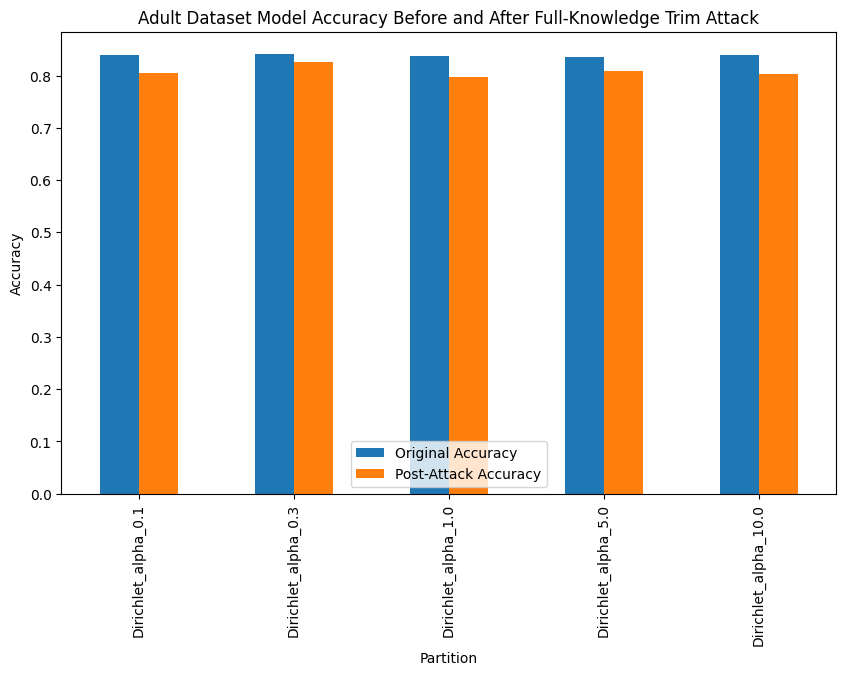

In [13]:
# Evaluate Results
results = []
device = "cuda" if torch.cuda.is_available() else "cpu"
test_loader = DataLoader(testset, batch_size=32, shuffle=False)

input_dim = trainset.data.shape[1]  # Adjust for Adult dataset input dimensions
for name, train_loader in original_loaders.items():
    print(f"Evaluating {name} Partition...")
    model = SimpleCNN(input_dim=input_dim)
    original_accuracy = train_model(
        model, train_loader, test_loader, epochs=50, device=device
    )

    print(f"Evaluating {name} Partition Post-Attack...")
    model = SimpleCNN(input_dim=input_dim)
    post_attack_accuracy = train_model(
        model, attack_loaders[name], test_loader, epochs=50, device=device
    )

    results.append(
        {
            "Partition": name,
            "Original Accuracy": original_accuracy,
            "Post-Attack Accuracy": post_attack_accuracy,
        }
    )

# Plot Results
results_df = pd.DataFrame(results)
results_df.set_index("Partition").plot(kind="bar", figsize=(10, 6))
plt.title("Adult Dataset Model Accuracy Before and After Full-Knowledge Trim Attack")
plt.ylabel("Accuracy")
plt.xlabel("Partition")
plt.savefig("FKTA_results_Adult.png", dpi=300)
plt.show()